In [34]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [35]:
# Path where our data is located
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
base_path = "./new_dataset/train/"

# Dictionary to save our 12 classes
categories = {0: 'Aloe vera', 1:"Angel_Trumpet", 2: 'Apple_tree', 3: 'Atiso', 4: 'Banana', 5: 'Banyan', 6: 'Cactus',
              7: 'Coconut', 8: 'Golden_shower', 9: 'Longan', 10: 'Mango', 11: 'Mangrove',
              12: 'Peach_blossom', 13: 'Pine_tree', 14: 'Potato', 15:'Red_pepper', 16:'Rhododendron', 17:'Royal_Poinciana', 18:'Tomato', 19:'Triticum aestivum'}

print('defining constants successful!')


defining constants successful!


In [36]:

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: re.sub(r'^(.*?)(_\d+_.*?)$', r'\1/\1\2', x))
    return df
# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  2134


In [37]:
#Change the categories from numbers to names

df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1707 validate size =  213 test size =  214


In [38]:
batch_size=64

train_datagen = image.ImageDataGenerator(
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1707 validated image filenames belonging to 20 classes.


In [39]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 213 validated image filenames belonging to 20 classes.


In [40]:
from keras.models import Sequential
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications import ResNet50 as resnet_50

res_layer = resnet_50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),classes=20)
res_layer.trainable = False

model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

model.add(res_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(20, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23628692 (90.14 MB)
Trainable params: 40980 (160.08 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [41]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [42]:
EPOCHS = 10
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/10
26/26 [==============================] - 112s 4s/step - loss: 1.9456 - categorical_accuracy: 0.4650 - val_loss: 0.9482 - val_categorical_accuracy: 0.7396
Epoch 2/10
26/26 [==============================] - 109s 4s/step - loss: 0.5648 - categorical_accuracy: 0.8923 - val_loss: 0.4430 - val_categorical_accuracy: 0.9219
Epoch 3/10
26/26 [==============================] - 93s 4s/step - loss: 0.2722 - categorical_accuracy: 0.9726 - val_loss: 0.2575 - val_categorical_accuracy: 0.9740
Epoch 4/10
26/26 [==============================] - 107s 4s/step - loss: 0.1609 - categorical_accuracy: 0.9970 - val_loss: 0.1597 - val_categorical_accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 108s 4s/step - loss: 0.1096 - categorical_accuracy: 0.9994 - val_loss: 0.1207 - val_categorical_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 108s 4s/step - loss: 0.0822 - categorical_accuracy: 1.0000 - val_loss: 0.0983 - val_categorical_accuracy: 1.0000
Epoch 6: ea

In [43]:
model.save('res_net.h5')

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


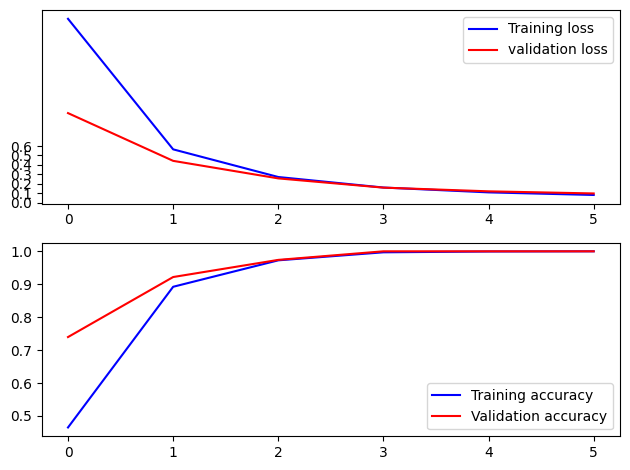

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
     
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(categories))
        plt.xticks(tick_marks, categories, rotation=90)
        plt.yticks(tick_marks, categories)
    
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        thresh = cm.max() / 2.
    
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, round(cm[i, j],2),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


In [46]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 214 validated image filenames belonging to 20 classes.


In [47]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 
#accuracy on the train set
_, accuracy = model.evaluate_generator(train_generator, nb_samples)
print('accuracy on train set = ',  round((accuracy * 100),2 ), '% ')

#accuracy on the validation set
_, accuracy = model.evaluate_generator(validation_generator, nb_samples)
print('accuracy on validation set = ',  round((accuracy * 100),2 ), '% ')

C:\Users\admin\AppData\Local\Temp\ipykernel_6172\3514746145.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  98.13 % 


C:\Users\admin\AppData\Local\Temp\ipykernel_6172\3514746145.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(train_generator, nb_samples)


accuracy on train set =  99.82 % 


C:\Users\admin\AppData\Local\Temp\ipykernel_6172\3514746145.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(validation_generator, nb_samples)


accuracy on validation set =  100.0 % 


In [48]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'Aloe vera', 1: 'Angel_Trumpet', 2: 'Apple_tree', 3: 'Atiso', 4: 'Banana', 5: 'Banyan', 6: 'Cactus', 7: 'Coconut', 8: 'Golden_shower', 9: 'Longan', 10: 'Mango', 11: 'Mangrove', 12: 'Peach_blossom', 13: 'Pine_tree', 14: 'Potato', 15: 'Red_pepper', 16: 'Rhododendron', 17: 'Royal_Poinciana', 18: 'Tomato', 19: 'Triticum aestivum'}


214/214 [==============================] - 15s 63ms/step


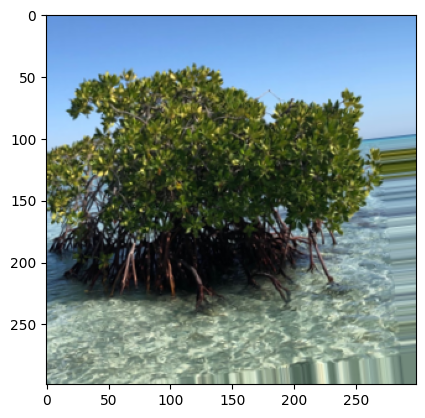

Image:  Mangrove/Mangrove_0_115.png
Predicted class:  Mangrove
Actual class:  Mangrove
------------------------------


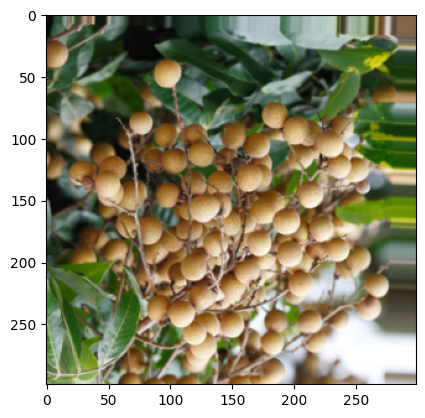

Image:  Longan/Longan_0_5510.png
Predicted class:  Longan
Actual class:  Longan
------------------------------


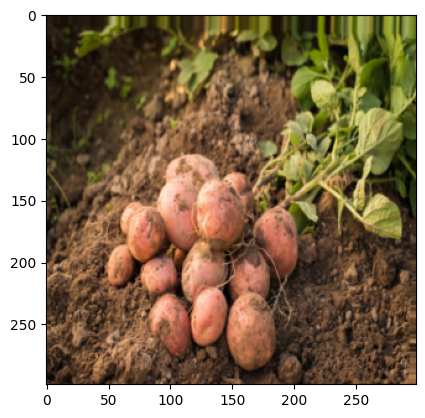

Image:  Potato/Potato_0_7673.png
Predicted class:  Potato
Actual class:  Potato
------------------------------


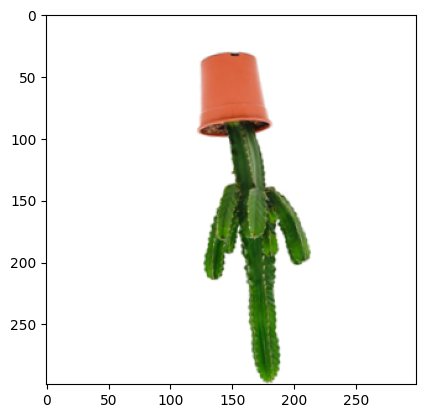

Image:  Cactus/Cactus_0_9027.png
Predicted class:  Cactus
Actual class:  Cactus
------------------------------


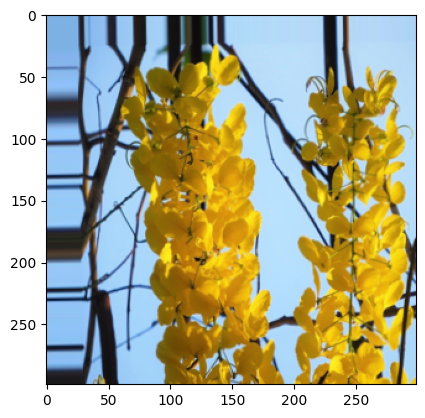

Image:  Golden_shower/Golden_shower_0_3826.png
Predicted class:  Golden_shower
Actual class:  Golden_shower
------------------------------


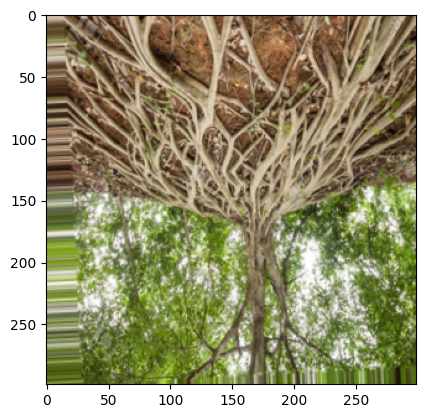

Image:  Banyan/Banyan_0_3840.png
Predicted class:  Banyan
Actual class:  Banyan
------------------------------


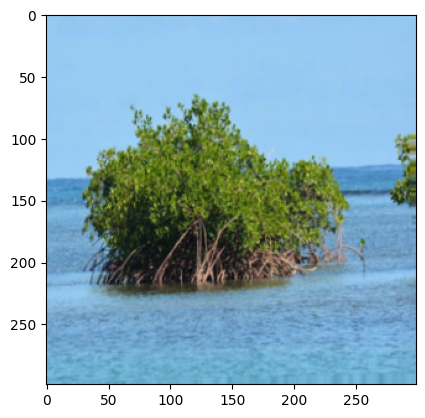

Image:  Mangrove/Mangrove_0_6965.png
Predicted class:  Pine_tree
Actual class:  Mangrove
------------------------------


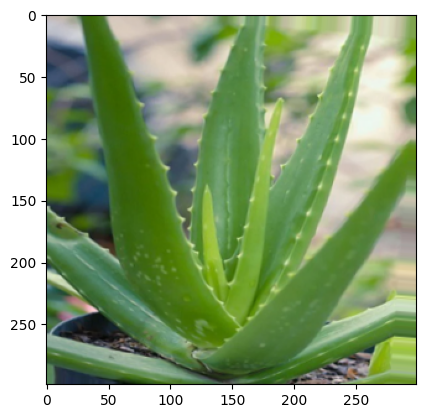

Image:  Aloe vera/Aloe vera_0_4026.png
Predicted class:  Aloe vera
Actual class:  Aloe vera
------------------------------


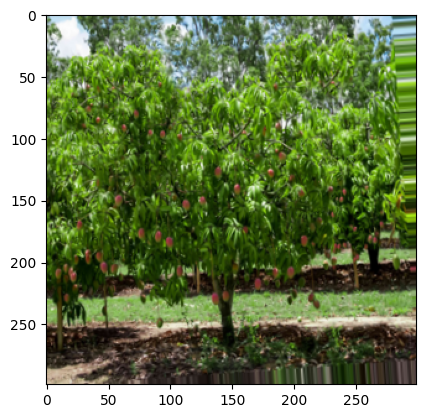

Image:  Mango/Mango_0_4111.png
Predicted class:  Mango
Actual class:  Mango
------------------------------


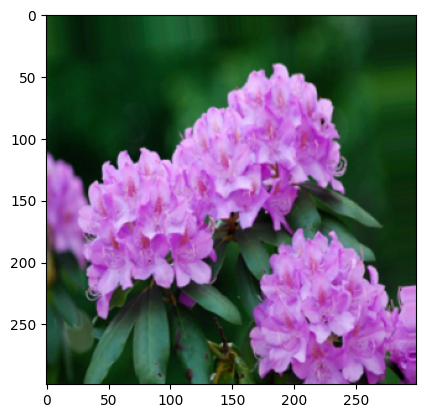

Image:  Rhododendron/Rhododendron_0_5851.png
Predicted class:  Rhododendron
Actual class:  Rhododendron
------------------------------


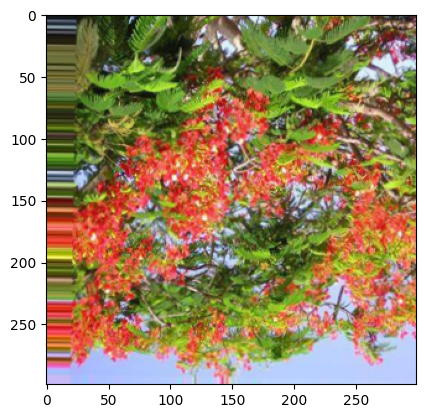

Image:  Royal_Poinciana/Royal_Poinciana_0_6358.png
Predicted class:  Royal_Poinciana
Actual class:  Royal_Poinciana
------------------------------


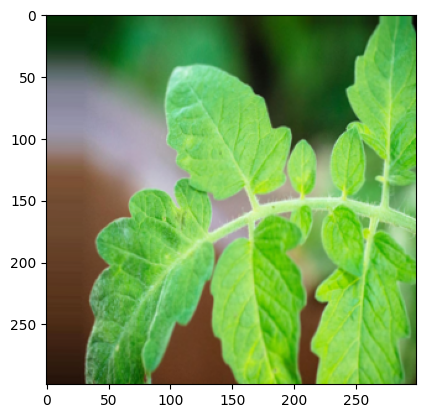

Image:  Tomato/Tomato_0_891.png
Predicted class:  Tomato
Actual class:  Tomato
------------------------------


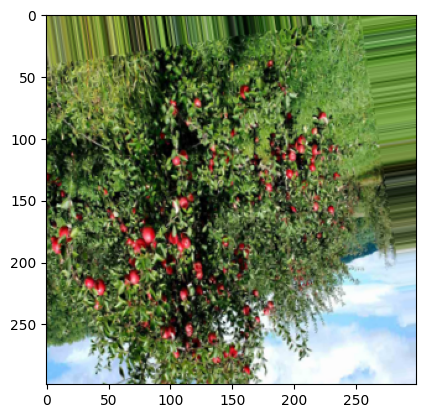

Image:  Apple_tree/Apple_tree_0_2396.png
Predicted class:  Apple_tree
Actual class:  Apple_tree
------------------------------


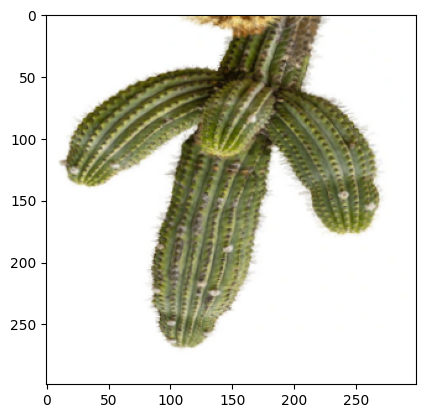

Image:  Cactus/Cactus_0_4402.png
Predicted class:  Cactus
Actual class:  Cactus
------------------------------


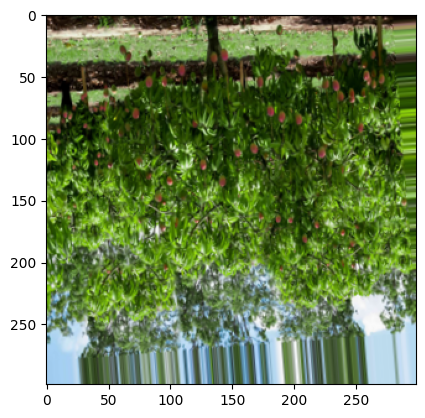

Image:  Mango/Mango_0_6459.png
Predicted class:  Mango
Actual class:  Mango
------------------------------


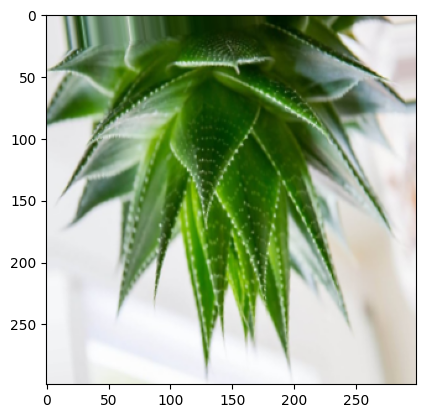

Image:  Aloe vera/Aloe vera_0_2326.png
Predicted class:  Aloe vera
Actual class:  Aloe vera
------------------------------


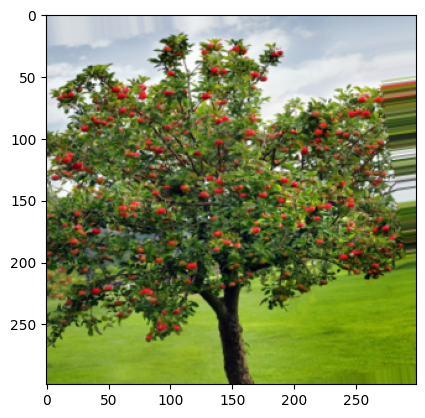

Image:  Apple_tree/Apple_tree_0_8042.png
Predicted class:  Apple_tree
Actual class:  Apple_tree
------------------------------


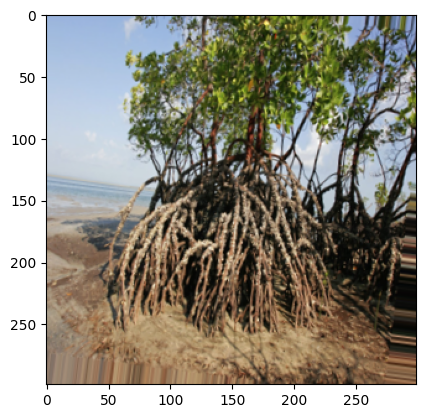

Image:  Mangrove/Mangrove_0_8715.png
Predicted class:  Mangrove
Actual class:  Mangrove
------------------------------


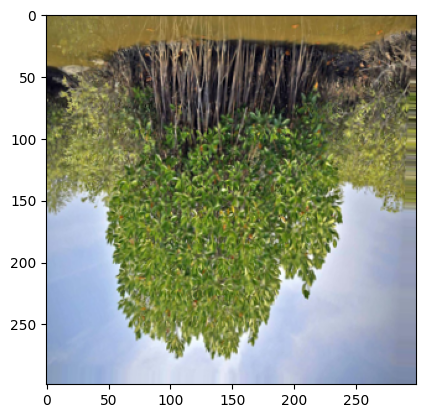

Image:  Mangrove/Mangrove_0_1724.png
Predicted class:  Mangrove
Actual class:  Mangrove
------------------------------


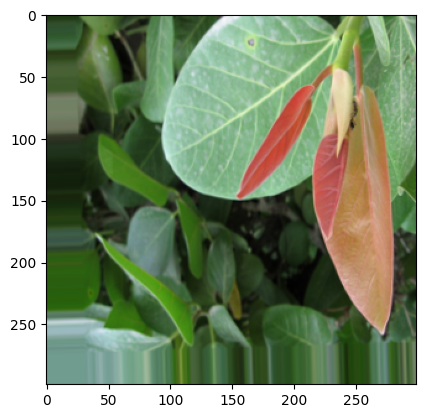

Image:  Banyan/Banyan_0_3073.png
Predicted class:  Banyan
Actual class:  Banyan
------------------------------
                   precision    recall  f1-score   support

        Aloe vera       1.00      1.00      1.00        10
    Angel_Trumpet       1.00      1.00      1.00         2
       Apple_tree       1.00      1.00      1.00        13
            Atiso       1.00      1.00      1.00        12
           Banana       1.00      1.00      1.00         9
           Banyan       0.94      1.00      0.97        15
           Cactus       1.00      1.00      1.00         8
          Coconut       1.00      1.00      1.00        12
    Golden_shower       1.00      0.92      0.96        13
           Longan       1.00      0.92      0.96        12
            Mango       0.91      1.00      0.95        10
         Mangrove       1.00      0.91      0.95        11
    Peach_blossom       1.00      1.00      1.00        10
        Pine_tree       0.88      1.00      0.93         7
   

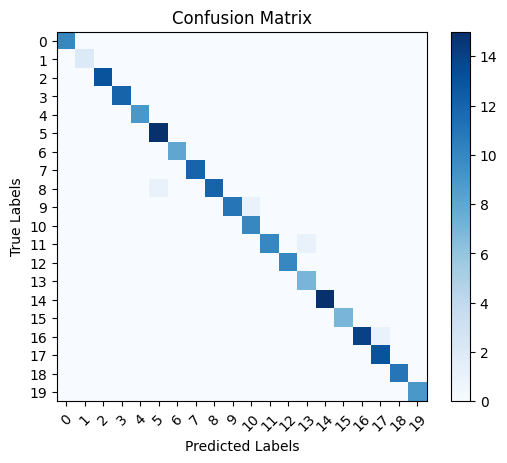

In [49]:
# get the model's predictions for the test set
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
# Convert the predicted category's number to name 
preds = [gen_label_map[item.argmax()] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

# Choose 10 random rows for display
random_rows = random.sample(range(len(test_df)), 20)

for random_row in random_rows:
    sample = test_df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    
    plt.imshow(random_image)
    plt.show()

    print('Image: ', sample['filename'])
    print('Predicted class: ', preds[random_row])
    print('Actual class: ', labels[random_row])
    print('-' * 30)

print(classification_report(labels, preds))
#confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(labels, preds)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)


plt.savefig("confusion matrix")
plt.show()